# **Progetto di Matteo Calvanico e Filippo Monti**

---
---

## Per quanto riguarda i CSV...

Per questo progetto useremo due CSV, eccoli nel dettaglio:
#### Fonti

> * [CSV 1](https://www.kaggle.com/datasets/mahmoudshogaa/us-crime-rates-1960-2014/)
> * [CSV 2](https://www.kaggle.com/datasets/guillemservera/us-unemployment-rates)

I csv sono stati presi dal [Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/), il database gestito dalla divisione di ricerca della Federal Reserve Bank di St. Louis.

#### Contenuto

> * Il CSV 1 contiene il numero di totale di crimini, divisi per categoria, avvenuti negli U.S.A dal 1960 al 2014.
>
> * Il CSV 2 contiene le percentuali dei cittadini senza lavoro negli U.S.A divise in diversi fattori (Es: età), a partire dal 1940 fino al 2023. La percentuale è stata registrta il 1° di ogni mese.

---

## Scopo

L'obiettivo finale che ci siamo posti è quello di capire se c'è una correlazione fra i dati riportati dai due csv.
In particolare vogliamo dimostrare o confutare che:

> All'aumentare del tasso di disoccupazione aumentino anche i crimini, concentrandoci nei furti di vario tipo.

&nbsp;

Successivamente tramite i dati che abbiamo proveremo a fare una previsione se la disoccupazione aumentera o diminuira nei prossimi anni.

---

# !!! Da cancellare prima della consegna !!!

## Idee implementative
* Sicuramente per il secondo obiettivo bisogna vedere le slides 'Time Series'
* Sempre per la previsione utile guardare la regressione lineare (La regressione lineare è ampiamente utilizzata in analisi statistica e machine learning per fare previsioni, analizzare relazioni e identificare pattern nei dati)

In [978]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm # ci serve per il QQ-plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict # per plottare ACF, PACF e previsione
from statsmodels.tsa.stattools import adfuller # per il test di verifica della stazionarietà della serie storica
from statsmodels.tsa.arima.model import ARIMA # per la stima del modello ARIMA

from numpy import int64 #Ci servirà nella modifica del csv
import matplotlib as mpl #Ci servirà per i colori dei grafici

#### Carichiamo i due CSV e li mostriamo

In [979]:
df_crime = pd.read_csv("CSV1.csv")
df_employment = pd.read_csv("CSV2.csv")

In [980]:
df_crime.head()

,Year,Population,Total,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
0,1960,179323175,3384200,288460,3095700,9110,17190,107840,154320,912100,1855400,328200
1,1961,182992000,3488000,289390,3198600,8740,17220,106670,156760,949600,1913000,336000
2,1962,185771000,3752200,301510,3450700,8530,17550,110860,164570,994300,2089600,366800
3,1963,188483000,4109500,316970,3792500,8640,17650,116470,174210,1086400,2297800,408300
4,1964,191141000,4564600,364220,4200400,9360,21420,130390,203050,1213200,2514400,472800


In [981]:
df_employment

,date,overall_rate,age_16_17_rate,age_16_19_rate,age_18_19_rate,age_16_24_rate,age_20_24_rate,age_25_34_rate,age_25_54_rate,age_35_44_rate,age_45_54_rate,age_20plus_rate,age_25plus_rate,age_55plus_rate
0,1948-01-01,3.4,9.4,8.5,8.3,6.8,5.8,3.0,2.5,2.0,2.2,3.0,2.6,2.9
1,1948-02-01,3.8,13.1,10.0,8.2,7.7,6.3,3.3,2.9,2.5,2.8,3.3,2.9,3.1
2,1948-03-01,4.0,13.0,10.5,8.9,8.7,7.6,2.9,2.8,2.7,2.6,3.5,2.8,3.0
3,1948-04-01,3.9,11.2,9.5,8.6,7.8,6.8,3.4,3.0,2.9,2.6,3.5,3.0,3.0
4,1948-05-01,3.5,6.5,7.0,7.9,6.7,6.6,3.0,2.7,2.6,2.4,3.3,2.8,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2023-08-01,3.8,11.9,12.3,12.7,8.6,7.1,3.9,3.1,3.0,2.5,3.4,3.0,2.7
908,2023-09-01,3.8,12.8,11.8,11.1,8.4,7.0,4.0,3.2,2.8,2.8,3.5,3.0,2.7
909,2023-10-01,3.8,14.7,13.1,12.5,8.8,7.0,4.2,3.2,2.9,2.4,3.5,3.1,2.7
910,2023-11-01,3.7,11.4,11.4,11.5,8.0,6.6,3.9,3.1,2.9,2.6,3.4,3.1,2.9


#### Modifica Data Frame secondo CSV 

Nel secondo csv le varie percentuali sono divise per diversi fattori e suddivise per mesi di ogni anno. Come prima operazione cancelliamo tutte le percentuali tranne quella totale, unica davvero utile al nostro obiettivo.

Successivamente andremo a raggruppare le percentuali per anno e non per mese

In [982]:
#Cancelliamo le colonne futili al nostro obiettivo
df_employment = df_employment.drop(columns=['age_16_17_rate', 'age_16_19_rate', 'age_18_19_rate', 'age_16_24_rate', 'age_20_24_rate', 'age_25_34_rate', 'age_25_54_rate', 'age_35_44_rate', 'age_45_54_rate', 'age_20plus_rate', 'age_25plus_rate', 'age_55plus_rate'])


#Convertiamo la data da String a DateTime per semplicità
df_employment['date'] = pd.to_datetime(df_employment['date'])


#Ora possiamo prendere l'anno con facilità
df_employment['anno'] = df_employment['date'].dt.year


#Raggruppiamo per anno e facciamo una media di tutte le percentuali di quell'anno
df_employment = df_employment.groupby('anno', as_index=False)['overall_rate'].mean()


#Arrotondiamo a due cifre dopo la virgola
df_employment['overall_rate'] = df_employment['overall_rate'].round(2)


#Rinomiamo le colonne
df_employment.columns = ['Anno', 'Percentuale_Media_Disoccupati']


#Mostriamo il nuovo Data Frame
df_employment

,Anno,Percentuale_Media_Disoccupati
0,1948,3.75
1,1949,6.05
2,1950,5.21
3,1951,3.28
4,1952,3.02
...,...,...
71,2019,3.68
72,2020,8.11
73,2021,5.35
74,2022,3.63


#### Andamento disoccupazione negli anni

Di sotto mostriamo come la disoccupazione negli U.S.A è cambiata negli anni. Possiamo notare come l'andamento cambia in maniera drastica e all'improvviso

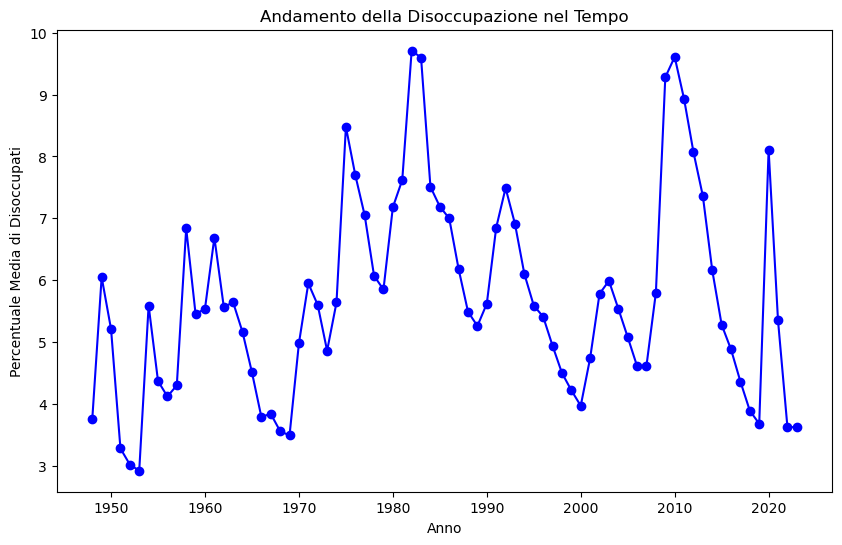

In [983]:
#Creiamo il grafico tramite Matplot
plt.figure(figsize=(10, 6))
plt.plot(df_employment['Anno'], df_employment['Percentuale_Media_Disoccupati'], marker='o', linestyle='-', color='b')


#Aggiungiamo titoli e etichette e visualizziamo
plt.title('Andamento della Disoccupazione nel Tempo')
plt.xlabel('Anno')
plt.ylabel('Percentuale Media di Disoccupati')
plt.show()

#### Andamento dei furti

Ora mostriamo come il numero di furti e scassi sono aumentati o diminuiti negli anni.

Come possiamo vedere i 'larceny theft', cioè i furti di beni personali di un'altra persona/azienda, hanno avuto un picco verso l'inizio degli anni 90. Invece gli altri sono andati a diminuire sempre nello stesso periodo.

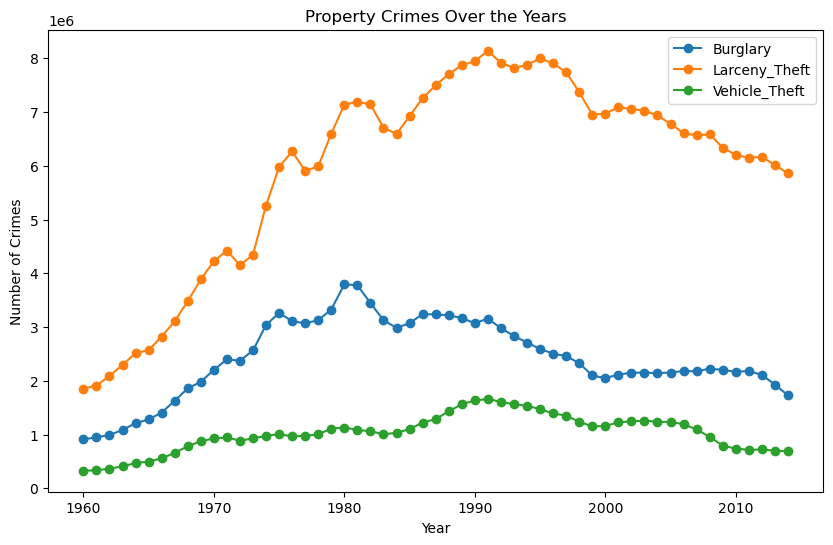

In [984]:
plt.figure(figsize=(10, 6))
plt.plot(df_crime['Year'], df_crime['Burglary'], label='Burglary', marker='o')
plt.plot(df_crime['Year'], df_crime['Larceny_Theft'], label='Larceny_Theft', marker='o')
plt.plot(df_crime['Year'], df_crime['Vehicle_Theft'], label='Vehicle_Theft', marker='o')

plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Property Crimes Over the Years')
plt.legend()
plt.show()

#### Merge dei due Data Frame

Ora per confrontare al meglio i due data frame dobbiamo unirli

In [985]:
#Prima però modifichiamo df_employment perchè il suo range di dati è più ampio di df_crime
df_employment = df_employment.loc[(df_employment['Anno'] >= 1960) & (df_employment['Anno'] <= 2014)]


#E modifichiamo anche il nome della colonna 'Year' in df_crime
df_crime.columns = ['Anno', 'Population', 'Total', 'Violent', 'Property', 'Murder', 'Forcible_Rape', 'Robbery', 'Aggravated_assault', 'Burglary', 'Larceny_Theft', 'Vehicle_Theft'] 


#Ora possiamo unire i due data frame
df_merged = df_crime.merge(df_employment, on=['Anno'])


#Mostriamo il nuovo data frame
df_merged.head()

,Anno,Population,Total,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft,Percentuale_Media_Disoccupati
0,1960,179323175,3384200,288460,3095700,9110,17190,107840,154320,912100,1855400,328200,5.54
1,1961,182992000,3488000,289390,3198600,8740,17220,106670,156760,949600,1913000,336000,6.69
2,1962,185771000,3752200,301510,3450700,8530,17550,110860,164570,994300,2089600,366800,5.57
3,1963,188483000,4109500,316970,3792500,8640,17650,116470,174210,1086400,2297800,408300,5.64
4,1964,191141000,4564600,364220,4200400,9360,21420,130390,203050,1213200,2514400,472800,5.16


### Ora il momento che tutti aspettavamo...

andiamo a controllare se effettivamente c'è una correlazione fra i dati.

Nello specifico:
#### 1) Useremo il metodo .corr() per calcolare la correlazione fra le varie colonne

Ricordiamo che il metodo corr() calcola il coefficiente di correlazione lineare, il valore varia tra -1 e 1. 
Dove:
* -1 indica nessuna correlazione, anzi i valori hanno andamenti opposti;
* 1 indica una correlazione perfetta;
* 0 assenza di correlazione;


In [986]:
matriceDiCorr = df_merged[['Percentuale_Media_Disoccupati', 'Burglary', 'Larceny_Theft', 'Vehicle_Theft']].corr()
matriceDiCorr

,Percentuale_Media_Disoccupati,Burglary,Larceny_Theft,Vehicle_Theft
Percentuale_Media_Disoccupati,1.000000,0.422118,0.291155,-0.003237
Burglary,0.422118,1.000000,0.734091,0.690423
Larceny_Theft,0.291155,0.734091,1.000000,0.885326
Vehicle_Theft,-0.003237,0.690423,0.885326,1.000000


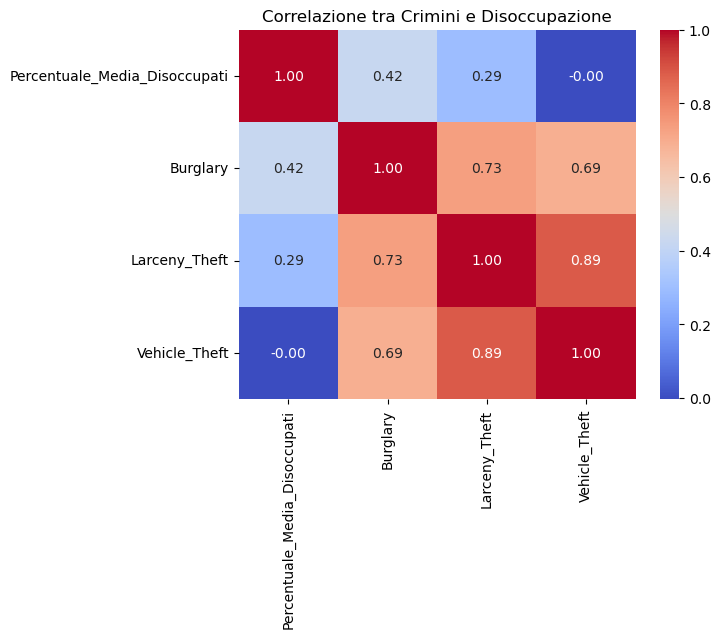

In [987]:
#Usiamo una heatmap per mostrare meglio i risultati
sns.heatmap(matriceDiCorr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlazione tra Crimini e Disoccupazione')
plt.show()

#### Risultati punto 1...

I risultati ci mostrano che fra:
* media disoccupati e i furti con scasso (burglary): c'è una correlazione moderata positiva;
* media disoccupati e i furti di beni personali (larceny): c'è una correlazione positiva ma meno forte della precedente;
* media disoccupati e i furti di auto: non c'è nessun tipo di correlazione

In conclusione è vero che un minimo di correlazione è presente ma comunque non mi sento in grado di affermare con certezze che all'umentare della disoccupazione aumentino anche i furti.

Gli altri risultati, anche se non interessanti ai nostri fini, sono tutti abbastanza correlati fra loro.

#### 2) Mostreremo i dati tramite scatter plot per vedere in maniera visiva una correlazione

Ora aggiungiamo una nuova colonna al data frame (Total_Theft), che conterrà tutta la somma dei furti, in questo modo possiamo vedere se c'è un'effettiva correlazione.

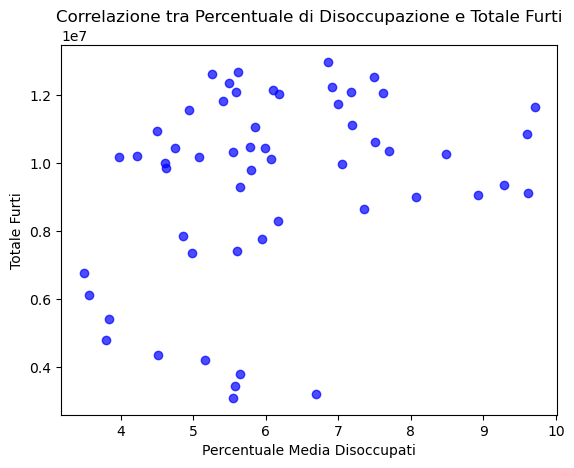

In [988]:
# Calcolo somma dei furti
df_merged['Total_Theft'] = df_merged['Burglary'] + df_merged['Larceny_Theft'] + df_merged['Vehicle_Theft']


# Creazione scatter plot
plt.scatter(df_merged['Percentuale_Media_Disoccupati'], df_merged['Total_Theft'], color='blue', alpha=0.7)


#Aggiunta etichette, titolo e mostriamo il plot
plt.xlabel('Percentuale Media Disoccupati')
plt.ylabel('Totale Furti')
plt.title('Correlazione tra Percentuale di Disoccupazione e Totale Furti')
plt.show()

#### Risultati punto 2...

Lo scatter plot ci mostra come non è presente una correlazione fra i furti e l'aumentar della disoccupazione, infatti i valori sono distanti fra loro e non seguono una direzione precisa.

## Parte II: previsione dati futuri

Ora proveremo a stimare l'andamento futuro della disoccupazione.

Prima però facciamo in modo di avere più dati possibili, andando a includere tutti gli anni dal '48 in poi

In [989]:
#Iniziamo ripopolando il data frame con tutti gli anni
df_employment = pd.read_csv("CSV2.csv")


#Cancelliamo le colonne futili
df_employment = df_employment.drop(columns=['age_16_17_rate', 'age_16_19_rate', 'age_18_19_rate', 'age_16_24_rate', 'age_20_24_rate', 'age_25_34_rate', 'age_25_54_rate', 'age_35_44_rate', 'age_45_54_rate', 'age_20plus_rate', 'age_25plus_rate', 'age_55plus_rate'])


#Convertiamo la colonna data
df_employment['date'] = pd.to_datetime(df_employment['date'])


#Mostriamo il risultato
df_employment

,date,overall_rate
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
907,2023-08-01,3.8
908,2023-09-01,3.8
909,2023-10-01,3.8
910,2023-11-01,3.7


Mostriamo velocemente l'andamento fino ad ora

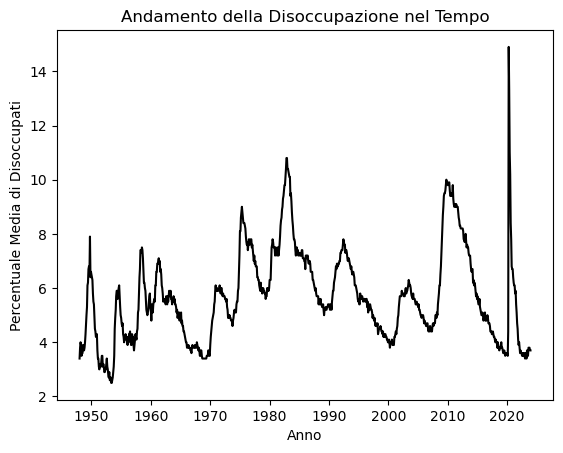

In [990]:
plt.plot(df_employment['date'], df_employment['overall_rate'], color='black')
plt.title('Andamento della Disoccupazione nel Tempo')
plt.xlabel('Anno')
plt.ylabel('Percentuale Media di Disoccupati')
plt.show()

#### Iniziamo a fare la previsione...

Prima di tutto dal grafico precedente possiamo intuire che non c'è stagionalità, non avendo fluttazioni regolari ogni tot

Per la stazionarietà effettueremo alcuni test, iniziamo mostrando la funzione di autocorrelazione globale (ACF), se l’ACF scenderà a zero abbastanza rapidamente la serie sarà stazionaria

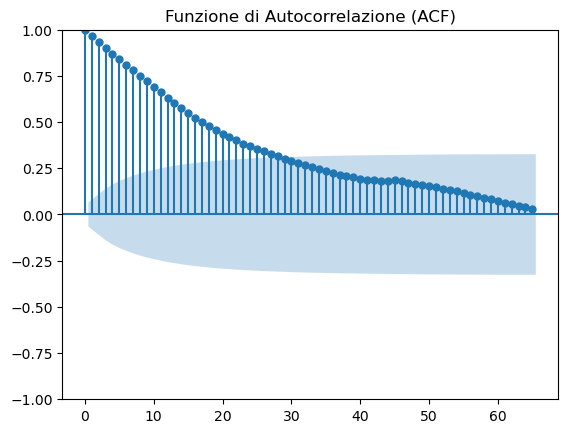

In [991]:
plot_acf(df_employment['overall_rate'], lags=65)
plt.title('Funzione di Autocorrelazione (ACF)')
plt.show()

Guardano il grafico è subito noto come la nostra serie temporale sia NON STAZIONARIA.

Ora cerchiamo di eliminare le fonti di non stazionarietà con la DIFFERENZIAZIONE, in questo modo avremo una serie storica stazionaria necessaria per identificare il modello ARIMA.

<Axes: >

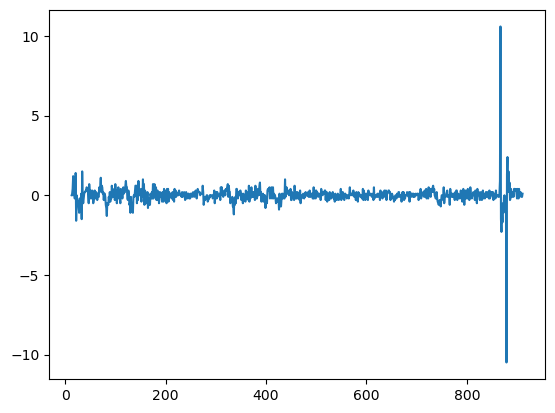

In [992]:
df_diff = df_employment["overall_rate"].diff().diff(12).dropna() #Con questo metodo eliminiano la presenza di trend e stagionalità che causano la non stazionarietà

#Mostriamo il risultato
df_diff.plot()

Ora possiamo passare all'identificazione del modello ARIMA.

Tramite ACF e PACF otteniamo i seguenti parametri del modello:
* q: deducibile dai primi 10-12 ritardi di ACF (num. di ritardi consecutivi in cui la funzione risulta diversa da 0);
* Q: deducibile dai ritardi stagionali di ACF (num. di ritardi consecutivi in cui la funzione assume valori significativi);
* p: deducibile dai primi 10-12 ritardi del PACF (num. di ritardi consecutivi in cui la funzione risulta diversa da 0);
* P: deducibile dai ritardi stagionali del PACF (num di ritardi consecutivi in cui la funzione assume valori significativi).

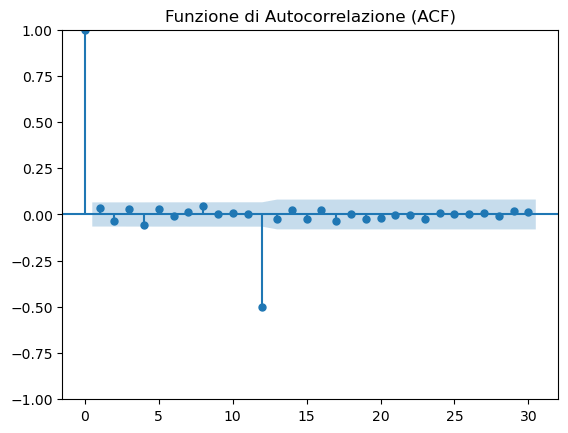

In [993]:
plot_acf(df_diff)
plt.title('Funzione di Autocorrelazione (ACF)')
plt.show()

Analizzando il grafico ACF vediamo che si ha un picco sull'12

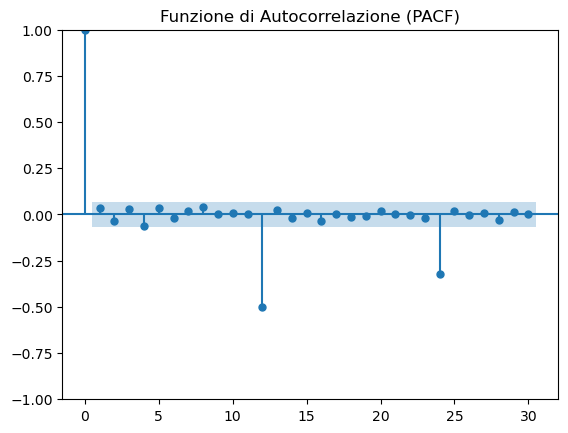

In [994]:
plot_pacf(df_diff)
plt.title('Funzione di Autocorrelazione (PACF)')
plt.show()

Analizzando il grafico PACF vediamo che abbiamo tre picchi, uno sul 12 e 24